# Laboratorium 2 - wieloręcy bandyci

## Przygotowanie

 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab2`
 * zainstaluj potrzebne biblioteki:
 `pip3 install matplotlib tabulate`
 * upewnij się, że plik `bandit_framework.py` najduje się w tym samym katalogu

## Część 1. - framework i naiwni bandyci

In [1]:
# importujemy wszystkie potrzebne pakiety

from copy import copy
from itertools import product
from math import log, sqrt
from tabulate import tabulate
from random import betavariate, normalvariate, random, sample, shuffle, uniform
from bandit_framework import * # pakiet ze srodowiskiem testowym

In [2]:
# inicjalizujemy parametry testu

runs = 50
epochs = 1000
recommendation_size = 10

In [4]:
# inicjalizujemy ramiona bandytow - payout kazdego ramienia bedzie reprezentowany przez rozklad normalny
#   te ramiona dobrze reprezentują CTR, czyli funkcje celu o rozkladzie Bernoulliego
#   - mamy prawdopodobienstwo aktywacji (klikniecia) p i staly payout po kliknieciu
# Mozemy takze przygotowac inne typy ramion, np. z payoutem losowanym z rozkladu normalnego lub wykladniczego

good_arms = [Arm(f'good_{i}', uniform(0.5, 0.7), lambda: 1) for i in range(10)]
bad_arms = [Arm(f'bad_{i}', uniform(0.1, 0.4), lambda: 1) for i in range(90)]
t = good_arms+bad_arms
shuffle(t)
arms = {arm.arm_id: arm for arm in t}
arm_ids = list(arms.keys())

In [7]:
expected_highest_payout_per_epoch = sum(sorted([arm.activation_probability for arm in arms.values()], reverse=True)[:10])
print(f'Expected highest average payout per epoch: {expected_highest_payout_per_epoch}')

Expected highest average payout per epoch: 5.972496312286414


In [53]:
# pierwszy bandyta - wybiera losowe ramiona

class Random(Bandit):
    def __init__(self, bandit_id, arm_ids):
        super().__init__(bandit_id, arm_ids)
    
    def recommend(self, size):
        return sample(self.arm_ids, size)
    
    def feedback(self, arm_id, payout):
        pass
    def reset(self):
        return super().reset()

In [54]:
# ten bandyta oszukuje - zna mozliwosci kazdego z ramion i wybiera najlepsze - przyda nam sie do porownania

class Perfect(Bandit):
    def __init__(self, bandit_id, arm_ids, arms):
        super().__init__(bandit_id, arm_ids)
        self.arms = arms
        self.expected_payouts = {}
        for arm in arms.values():
            self.expected_payouts[arm.arm_id] = self.__find_expected_value(arm.payout_function) * arm.activation_probability
        self.arm_ids_sorted_by_expected_payout = [x[0] for x in sorted(self.expected_payouts.items(), key=lambda x: x[1], reverse=True)]

    def recommend(self, size):
        return self.arm_ids_sorted_by_expected_payout[:size]
    
    def feedback(self, arm_id, payout):
        pass
    
    def __find_expected_value(self, payout_function, n=100000):
        # brzydka, ale skuteczna sztuczka, zeby metoda brute-force znalexc wartosc oczekiwana
        return sum([payout_function() for i in range(n)]) / n
    
    def reset(self):
        return super().reset()

In [55]:
# tworzymy liste bandytow do przetestowania

bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms),
    
]

In [56]:
# uruchamiamy test

runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect



Aggregated results:

perfect: 5995.799999999994
random: 2920.6400000000044


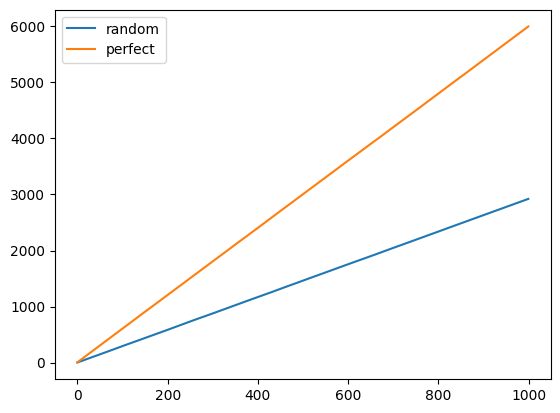

In [57]:
# wyniki sumaryczne dla wszystkich epok

runner.plot_results(results, runs, epochs, mode='cumulative')


Aggregated results:

perfect: 6.04
random: 2.86


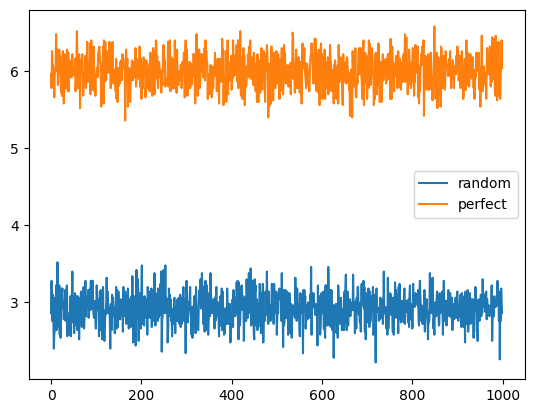

In [58]:
# wyniki per epoka

runner.plot_results(results, runs, epochs, mode='average')

## Część 2. - bandyci właściwi

In [59]:
class EGreedy(Bandit):
    def __init__(self, bandit_id, arm_ids, epsilon):
        super().__init__(bandit_id, arm_ids)
        self.epsilon = epsilon

        self.recommended_rates = {arm_id: 0 for arm_id in arm_ids}
        self.activation_rates = {arm_id: 0 for arm_id in arm_ids}
        self.payouts = {arm_id: 0.0 for arm_id in arm_ids}
        self.payouts_per_recommendation = {arm_id: 0.0 for arm_id in arm_ids}
        self.last_recommended = []
    
    def recommend(self, size):
        
        for arm in self.last_recommended:
            self.payouts_per_recommendation[arm] = self.payouts[arm]/self.recommended_rates[arm]
        self.last_recommended = []
        
        best_list = sorted(self.payouts_per_recommendation.items(), key=lambda x : -x[1])
        random_list = sample(list(self.payouts_per_recommendation.items()), len(self.payouts_per_recommendation))
        
        recommendations = []
        j = 0
        for i in range(size):
            while True:
                sample_recommend = best_list[i+j][0] if random()>self.epsilon else random_list[i+j][0]
                if(sample_recommend not in recommendations): break
                j+=1
                    
            self.recommended_rates[sample_recommend] += 1
            recommendations.append(sample_recommend)
            self.last_recommended.append(sample_recommend)
            # print(i)
        return recommendations
    
    def reset(self):
        self.recommended_rates = {arm_id: 0 for arm_id in self.arm_ids}
        self.activation_rates = {arm_id: 0 for arm_id in self.arm_ids}
        self.payouts = {arm_id: 0.0 for arm_id in self.arm_ids}
        self.payouts_per_recommendation = {arm_id: 0.0 for arm_id in self.arm_ids}
        self.last_recommended = []
    
    def feedback(self, arm_id, payout):
        self.activation_rates[arm_id] += 1
        self.payouts[arm_id] += payout

Simulating: random
Simulating: perfect
Simulating: egreedy 0.01
Simulating: egreedy 0.05
Simulating: egreedy 0.1
Simulating: egreedy 0.25
Simulating: egreedy 0.5

Aggregated results:

perfect: 5.96
egreedy 0.1: 5.38
egreedy 0.01: 5.22
egreedy 0.25: 5.18
egreedy 0.05: 5.16
egreedy 0.5: 4.46
random: 2.82


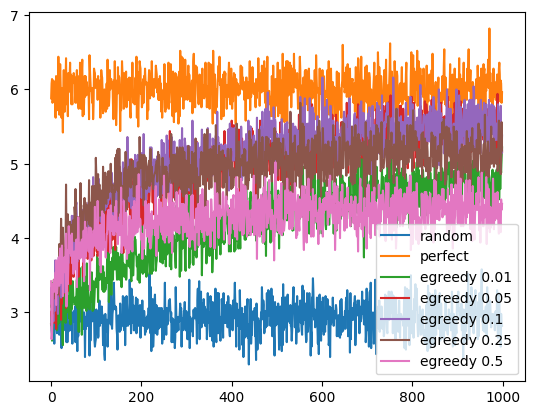

In [60]:
bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms),
    *[EGreedy(f'egreedy {i}', arm_ids, i) for i in [0.01, 0.05, 0.1, 0.25, 0.5]],
    
]
# uruchamiamy test

runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

# wyniki per epoka

runner.plot_results(results, runs, epochs, mode='average')


Aggregated results:

perfect: 6005.9399999999905
egreedy 0.1: 5101.919999999996
egreedy 0.05: 4966.240000000004
egreedy 0.25: 4917.880000000003
egreedy 0.5: 4254.38
egreedy 0.01: 4208.820000000003
random: 2925.1800000000035


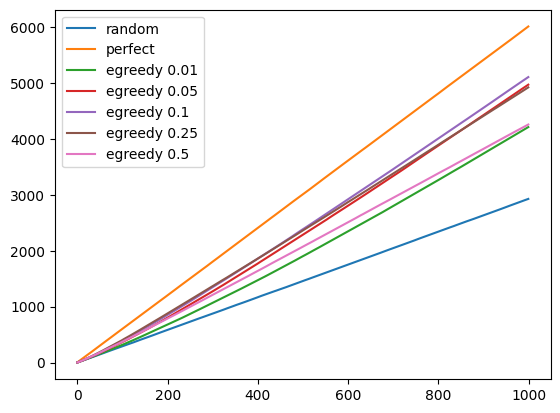

In [61]:
runner.plot_results(results, runs, epochs, mode='cumulative')

In [62]:
class UCB(Bandit):
    def __init__(self, bandit_id, arm_ids, optimism_weight):
        super().__init__(bandit_id, arm_ids)
        self.optimism_weight = optimism_weight

        self.recommended_rates = {arm_id: 0 for arm_id in arm_ids}
        self.activation_rates = {arm_id: 0 for arm_id in arm_ids}
        self.payouts = {arm_id: 0.0 for arm_id in arm_ids}
        self.payouts_per_recommendation = {arm_id: 0.0 for arm_id in arm_ids}
        self.n = 0

        self.optimism = {arm_id: float('+inf') for arm_id in arm_ids}
        self.last_recommended = []
    
    def recommend(self, size):


        for arm in self.last_recommended:
            self.payouts_per_recommendation[arm] = self.payouts[arm]/self.recommended_rates[arm]
        self.last_recommended = []
        
        optimism = {arm_id: self._optimism(arm_id) for arm_id in self.arm_ids}

        best_list = sorted(self.payouts_per_recommendation.items(), key=lambda x : x[1] + self.optimism_weight*optimism[x[0]], reverse=True)

        self.last_recommended = list(map(lambda x: x[0], best_list[:size]))
        for r in self.last_recommended:
            self.recommended_rates[r] += 1
        
        return self.last_recommended
    
    def feedback(self, arm_id, payout):
        self.activation_rates[arm_id] += 1
        self.payouts[arm_id] += payout
        self.n += 1

    def _optimism(self, arm):
        return sqrt(2*log(self.n)/self.activation_rates[arm]) if self.activation_rates[arm]!=0 else float('+inf')
    
    def reset(self):
        self.recommended_rates = {arm_id: 0 for arm_id in arm_ids}
        self.activation_rates = {arm_id: 0 for arm_id in arm_ids}
        self.payouts = {arm_id: 0.0 for arm_id in arm_ids}
        self.payouts_per_recommendation = {arm_id: 0.0 for arm_id in arm_ids}
        self.n = 0

        self.last_recommended = []


In [63]:
class ThompsonSampling(Bandit):
    def __init__(self, bandit_id, arm_ids, reward_multiplier, regret_multiplier):
        super().__init__(bandit_id, arm_ids)
        self.reward_multiplier = reward_multiplier
        self.regret_multiplier = regret_multiplier
        self.a = {arm_id: 1 for arm_id in arm_ids}
        self.b = {arm_id: 1 for arm_id in arm_ids}
    
    def recommend(self, size):
        beta = {arm_id: betavariate(self.a[arm_id], self.b[arm_id]) for arm_id in self.arm_ids}
        best = list(map(lambda x: x[0], sorted(beta.items(), key=lambda x: x[1], reverse=True)))[:size]
        for b in best:
            self.b[b] += self.regret_multiplier
        return best
    
    def feedback(self, arm_id, payout):
        self.a[arm_id] += payout*self.reward_multiplier
        self.b[arm_id] -= 1*self.regret_multiplier

    def reset(self):
        self.a = {arm_id: 1 for arm_id in arm_ids}
        self.b = {arm_id: 1 for arm_id in arm_ids}

Simulating: random
Simulating: perfect
Simulating: thomspson 1-1
Simulating: thomspson 2-1
Simulating: thomspson 1-2

Aggregated results:

perfect: 6.14
thomspson 1-2: 4.7
thomspson 2-1: 4.6
thomspson 1-1: 4.42
random: 2.94


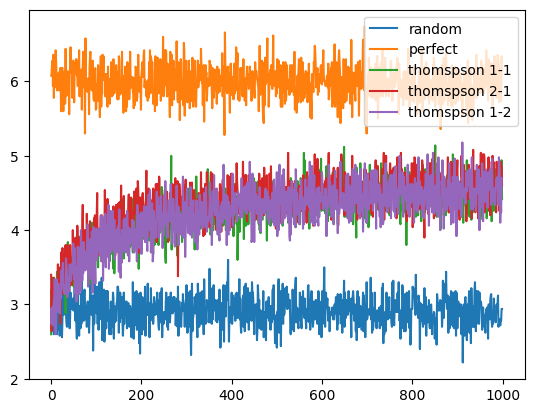

In [64]:
bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms),
    #*[EGreedy(f'egreedy {i}', arm_ids, i) for i in [0.01, 0.05, 0.1, 0.25, 0.5]],
    #*[UCB(f'ucb {i}', arm_ids, i) for i in [0.05, 0.01, 0.25, 0.5, 1]],
    *[ThompsonSampling(f'thomspson {reward}-{regret}', arm_ids, reward, regret) for (reward, regret) in [(1,1), (2,1), (1,2)]]
]

# uruchamiamy test

runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

# wyniki per epoka

runner.plot_results(results, runs, epochs, mode='average')



Aggregated results:

perfect: 5997.419999999996
thomspson 2-1: 4368.479999999998
thomspson 1-1: 4232.899999999998
thomspson 1-2: 4231.180000000006
random: 2913.5600000000045


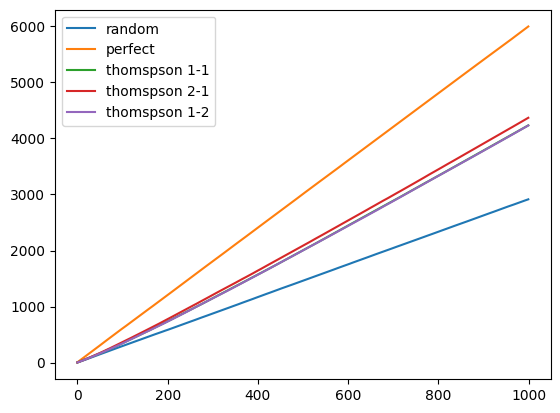

In [65]:
runner.plot_results(results, runs, epochs, mode='cumulative')

## Część 3. - zgrubne porównanie bandytów

In [66]:
bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]
# nie wahaj sie wybrac innych wartosci parametrow bandytow
bandits.extend([EGreedy('egreedy_%s' % epsilon, arm_ids, epsilon) for epsilon in [0.01, 0.05, 0.1, 0.25]])
bandits.extend([UCB('ucb_%s' % optimism_weight, arm_ids, optimism_weight) for optimism_weight in [0.01, 0.1, 1, 10]])
bandits.extend([ThompsonSampling('ts_%s_%s' % (reward_weight, regret_weight), arm_ids, reward_weight, regret_weight)
                for reward_weight, regret_weight in product([1, 5, 10, 20, 50], [1, 5, 10, 20, 50])])

In [67]:
runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect
Simulating: egreedy_0.01
Simulating: egreedy_0.05
Simulating: egreedy_0.1
Simulating: egreedy_0.25
Simulating: ucb_0.01
Simulating: ucb_0.1
Simulating: ucb_1
Simulating: ucb_10
Simulating: ts_1_1
Simulating: ts_1_5
Simulating: ts_1_10
Simulating: ts_1_20
Simulating: ts_1_50
Simulating: ts_5_1
Simulating: ts_5_5
Simulating: ts_5_10
Simulating: ts_5_20
Simulating: ts_5_50
Simulating: ts_10_1
Simulating: ts_10_5
Simulating: ts_10_10
Simulating: ts_10_20
Simulating: ts_10_50
Simulating: ts_20_1
Simulating: ts_20_5
Simulating: ts_20_10
Simulating: ts_20_20
Simulating: ts_20_50
Simulating: ts_50_1
Simulating: ts_50_5
Simulating: ts_50_10
Simulating: ts_50_20
Simulating: ts_50_50



Aggregated results:

perfect: 6.04
egreedy_0.05: 5.48
egreedy_0.1: 5.34
ucb_0.1: 5.32
egreedy_0.25: 5.3
ts_1_20: 5.14
ucb_0.01: 4.98
egreedy_0.01: 4.86
ts_5_1: 4.8
ucb_1: 4.74
ts_5_20: 4.68
ts_5_5: 4.6
ts_10_50: 4.6
ts_20_5: 4.58
ts_50_10: 4.58
ts_1_1: 4.54
ts_5_10: 4.52
ts_5_50: 4.5
ts_10_1: 4.5
ts_10_10: 4.48
ts_1_5: 4.42
ts_1_10: 4.42
ts_10_20: 4.42
ts_20_50: 4.42
ts_20_20: 4.38
ts_1_50: 4.36
ts_10_5: 4.28
ts_20_10: 4.28
ts_50_50: 4.28
ts_50_5: 4.18
ts_50_20: 4.12
ts_50_1: 4.06
ts_20_1: 3.98
random: 3.1
ucb_10: 3.02


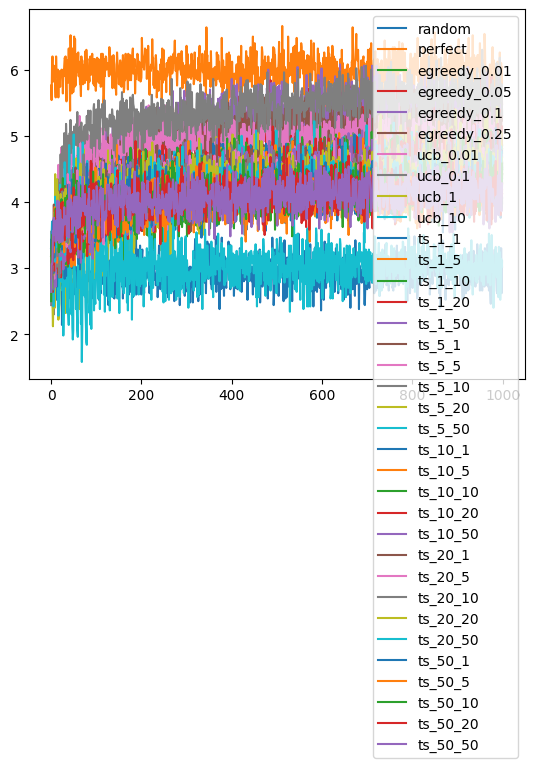

In [68]:
runner.plot_results(results, runs, epochs, mode='average')


Aggregated results:

perfect: 5989.499999999996
ucb_0.1: 5376.260000000009
egreedy_0.1: 5209.260000000002
egreedy_0.05: 4985.539999999998
egreedy_0.25: 4938.4
ucb_0.01: 4863.419999999997
ts_5_1: 4422.959999999994
ts_5_20: 4411.000000000001
ts_5_50: 4395.560000000002
ts_5_10: 4381.500000000004
ts_10_10: 4377.340000000002
ts_10_50: 4371.260000000001
ts_10_20: 4370.039999999999
ts_5_5: 4363.899999999999
ts_10_1: 4362.799999999999
ts_10_5: 4309.300000000004
ts_20_20: 4309.260000000006
ts_20_1: 4267.640000000002
ts_1_10: 4263.560000000001
ts_20_5: 4231.619999999998
ts_1_20: 4231.560000000003
ts_1_50: 4225.679999999999
ts_1_5: 4210.900000000001
ucb_1: 4207.9000000000015
ts_20_10: 4206.560000000004
ts_20_50: 4201.939999999999
ts_1_1: 4181.68
egreedy_0.01: 4167.080000000003
ts_50_1: 4099.859999999996
ts_50_10: 4083.7399999999975
ts_50_20: 4070.299999999999
ts_50_50: 4061.6800000000007
ts_50_5: 4026.940000000007
ucb_10: 3017.6200000000013
random: 2920.7800000000034


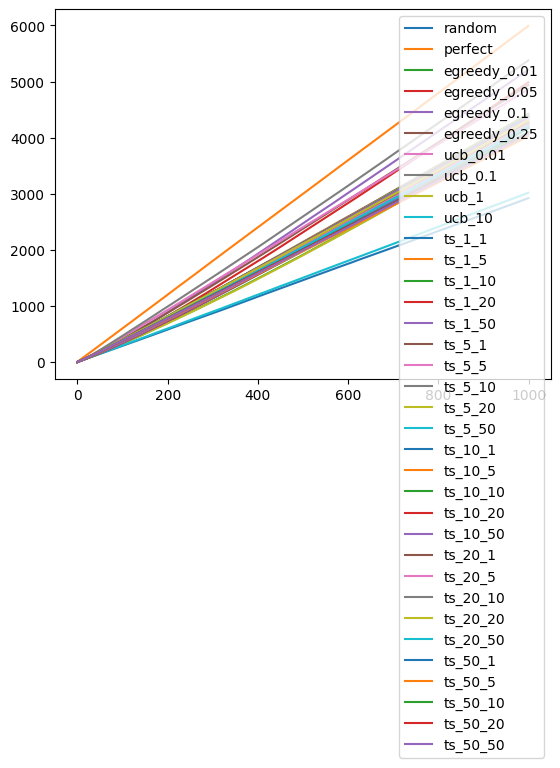

In [69]:
runner.plot_results(results, runs, epochs, mode='cumulative')

## Część 4. - dokładne porównanie bandytów

In [70]:
# obliczmy liste wszystkich dobrych ramion (arm_id zaczyna sie od 'good_') w rekomendacji
def relevant(recommendation: List[Arm]) -> int:
    return len([arm for arm in recommendation if arm.arm_id.startswith('good')])

all_relevant = relevant(arms.values())

In [71]:
# obliczmy precision@k i recall@k (na bazie funkcji relevant())
def precision_at_k(recommendation: List[Arm], k: int) -> float:
   recommendation_relevant = relevant(recommendation)
   return recommendation_relevant/k


def recall_at_k(recommendation: List[Arm], k: int, all_relevant: int) -> float:
   recommendation_relevant = relevant(recommendation) 
   return recommendation_relevant/all_relevant

In [72]:
# sprawdzmy, czy dziala
sample_bandit = bandits[-1]
k = 3
recommendation_ids = sample_bandit.recommend(recommendation_size)
recommendation = [arms[arm_id] for arm_id in recommendation_ids]
print(f'Precision@{k} for bandit {sample_bandit.bandit_id}: {precision_at_k(recommendation, k)}')
print(f'Recall@{k} for bandit {sample_bandit.bandit_id}: {recall_at_k(recommendation, k, all_relevant)}')

Precision@3 for bandit ts_50_50: 1.0
Recall@3 for bandit ts_50_50: 0.3


In [73]:
class TestEntry():
    def __init__(self, bandit_name: str, k: int, precision: float, recall: float):
        self.bandit_name = bandit_name
        self.k = k
        self.precision = precision
        self.recall = recall
    
    def tuple(self):
        return (self.bandit_name, self.k, self.precision, self.recall)


def print_test_results(entries: List[TestEntry]):
    data = sorted(sorted([e.tuple() for e in entries], key=lambda e: e[1]), key=lambda e: e[0])
    headers = ('bandit', 'k', 'precision@k', 'recall@k')
    return tabulate(data, headers, tablefmt='github')

In [75]:
# wybieramy kilku istniejacych, wytrenowanych bandytow (perfect, random, po jednym e-greedy, UCB, TS)
tesing_bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms),
    EGreedy(f'egreedy {0.1}', arm_ids, 0.1),
    UCB(f'ucb {0.1}', arm_ids, 0.1),
    ThompsonSampling(f'thomspson {1}-{20}', arm_ids, 1, 20)
]
# wybieramy wartosci k do porownania
k_vals = [3, 5, 10]
# bedziemy liczyc sredni precision i recall dla `samples` rekomendacji
samples = 10
# miejsce na wyniki
results = []

runner = Runner(arms, tesing_bandits)
runner.simulate(1, epochs, recommendation_size)

for bandit in tesing_bandits:
    precision_sum = [0 for _ in range(len(k_vals))]
    recall_sum = [0 for _ in range(len(k_vals))]
    for _ in range(samples):
        recommendation_ids = bandit.recommend(recommendation_size)
        recommendation = [arms[arm_id] for arm_id in recommendation_ids]
        for i, k in enumerate(k_vals):
            precision_sum[i] += precision_at_k(recommendation[:k], k)
            recall_sum[i] += recall_at_k(recommendation[:k], k, all_relevant)
    for i, k in enumerate(k_vals):
        results.append(TestEntry(bandit.bandit_id, k, precision_sum[i]/samples, recall_sum[i]/samples))

# dla kazdego bandyty - genetujemy `samples` rekomendacji, liczymy precision i recall, zapisujemy srednie wartosci
# powtarzamy dla kazdego k

# uwaga! przed przeprowadzeniem porownania, bandyci musza sie nauczyc
# pamietaj o uruchomieniu `runner.simulate()` w poprzedniej czesci

print(print_test_results(results))

Simulating: random
Simulating: perfect
Simulating: egreedy 0.1
Simulating: ucb 0.1
Simulating: thomspson 1-20
| bandit         |   k |   precision@k |   recall@k |
|----------------|-----|---------------|------------|
| egreedy 0.1    |   3 |      1        |       0.3  |
| egreedy 0.1    |   5 |      0.98     |       0.49 |
| egreedy 0.1    |  10 |      0.98     |       0.98 |
| perfect        |   3 |      1        |       0.3  |
| perfect        |   5 |      1        |       0.5  |
| perfect        |  10 |      1        |       1    |
| random         |   3 |      0.166667 |       0.05 |
| random         |   5 |      0.12     |       0.06 |
| random         |  10 |      0.12     |       0.12 |
| thomspson 1-20 |   3 |      0.166667 |       0.05 |
| thomspson 1-20 |   5 |      0.18     |       0.09 |
| thomspson 1-20 |  10 |      0.2      |       0.2  |
| ucb 0.1        |   3 |      1        |       0.3  |
| ucb 0.1        |   5 |      1        |       0.5  |
| ucb 0.1        |  10 |  